# Transfer Learning

In [1]:
import math
import pandas as pd
import numpy as np
import warnings
import spacy
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


import transformers
from tokenizers import BertWordPieceTokenizer

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertModel, DistilBertTokenizer
import torch.nn as nn
import torch.optim as optim

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


In [2]:
if torch.cuda.is_available():
    print(f"CUDA is available! GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available! GPU name: NVIDIA GeForce RTX 4060 Ti


## Load data

In [3]:
df_train = pd.read_csv('data/train_data.txt', header=None, delimiter=';')
df_test = pd.read_csv('data/test_data.txt', header=None, delimiter=';')

df_train = df_train.rename(columns= {0: 'text', 1: 'feeling'})
df_test = df_test.rename(columns= {0: 'text', 1: 'feeling'})

print(df_train.shape)
print(df_test.shape)

display(df_train.head(3))
display(df_test.head(3))

(16000, 2)
(2000, 2)


,text,feeling
0,i am feeling completely overwhelmed i have two strategies that help me to feel grounded pour my heart out in my journal in the form of a letter to god and then end with a list of five things i am most grateful for,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your support and encouragement is a great feeling and i am so glad you were able to help me,joy


,text,feeling
0,i feel like my only role now would be to tear your sails with my pessimism and discontent,sadness
1,i feel just bcoz a fight we get mad to each other n u wanna make a publicity n let the world knows about our fight,anger
2,i feel like reds and purples are just so rich and kind of perfect,joy


In [4]:
df_train['feeling'].value_counts()

feeling
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [5]:
df_test['feeling'].value_counts()

feeling
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

> The column **text** will be the input feature and **feeling** will be the output target.

## Data preprocessing using Spacy

**Spacy** is an open-source library for advanced Natural Language Processing (NLP) in Python, designed specifically for production use with a focus on performance and ease of use. It provides fast and efficient processing, making it suitable for large datasets and real-time applications. The library includes pre-trained models for various languages, offering capabilities such as tokenization, part-of-speech tagging, named entity recognition, dependency parsing, lemmatization, and text classification. 

The user-friendly API allows you to implement complex NLP tasks with minimal code, and it integrates seamlessly with other libraries like TensorFlow and PyTorch. Additionally, spaCy supports the creation of custom pipelines and model training, ensuring flexibility for specific project needs. Its active community, comprehensive documentation, and ongoing development make it a reliable choice for anyone looking to incorporate robust NLP functionalities into their projects. Overall, spaCy is ideal for applications that require efficient text processing and analysis, making it a popular choice among data scientists and developers. [Oficial site](https://spacy.io/).

In [8]:
# !python -m spacy download en_core_web_md -q

In [9]:
# Load the dict
spacy_nlp = spacy.load('en_core_web_md')

In [10]:
# Definition of the 'data_preprocessing' function that receives a text as a parameter
def data_preprocessing(text):

    # Process the text using the dictionary
    doc = spacy_nlp(text)

    # Creates a list of lemmas from the tokens, converted to lowercase and without whitespace,
    # excluding words that are stopwords
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]

    # Returns the processed tokens as a single string, joining them with spaces
    return ' '.join(tokens)

In [11]:
df_train['transformed_text'] = df_train['text'].apply(data_preprocessing)
df_test['transformed_text'] = df_test['text'].apply(data_preprocessing)

In [12]:
display(df_train.head())
display(df_test.head())

,text,feeling,transformed_text
0,i am feeling completely overwhelmed i have two strategies that help me to feel grounded pour my heart out in my journal in the form of a letter to god and then end with a list of five things i am most grateful for,fear,feel completely overwhelmed strategy help feel grounded pour heart journal form letter god end list thing grateful
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your support and encouragement is a great feeling and i am so glad you were able to help me,joy,able help chai lifeline support encouragement great feeling glad able help
3,i already feel like i fucked up though because i dont usually eat at all in the morning,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i can no longer tolerate the effect that bm has on our lives and the fact that is has turned my so into a bitter angry person who is not always particularly kind to the people around him when he is feeling stressed,sadness,love wish good long tolerate effect bm life fact turn bitter angry person particularly kind people feel stress


,text,feeling,transformed_text
0,i feel like my only role now would be to tear your sails with my pessimism and discontent,sadness,feel like role tear sail pessimism discontent
1,i feel just bcoz a fight we get mad to each other n u wanna make a publicity n let the world knows about our fight,anger,feel bcoz fight mad n u wanna publicity n let world know fight
2,i feel like reds and purples are just so rich and kind of perfect,joy,feel like red purple rich kind perfect
3,im not sure the feeling of loss will ever go away but it may dull to a sweet feeling of nostalgia at what i shared in this life with my dad and the luck i had to have a dad for years,sadness,m sure feeling loss away dull sweet feeling nostalgia share life dad luck dad year
4,i feel like ive gotten to know many of you through comments and emails and for that im appreciative and glad you are a part of this little space,joy,feel like ve get know comment email m appreciative glad little space


## HuggingFace Platform

Hugging Face is a prominent AI research organization and platform that focuses on natural language processing (NLP) and machine learning. It is best known for its user-friendly libraries and tools that facilitate the development, training, and deployment of state-of-the-art machine learning models, particularly those based on transformer architectures. Here are some key aspects of the Hugging Face platform:

**Key Features**

1. **Transformers Library**:
   - The `Transformers` library provides access to a wide variety of pre-trained models for NLP tasks, such as text classification, translation, summarization, and named entity recognition. The library supports models like BERT, GPT-2, RoBERTa, T5, and many more.

2. **Datasets Library**:
   - Hugging Face offers the `Datasets` library, which provides easy access to a large collection of datasets for machine learning tasks. This library simplifies loading, processing, and sharing datasets across various projects.

3. **Tokenizers Library**:
   - The `Tokenizers` library is designed for efficient tokenization, providing tools to preprocess text data for various NLP tasks. It supports multiple tokenization algorithms, including Byte Pair Encoding (BPE) and WordPiece.

4. **Model Hub**:
   - Hugging Face hosts a Model Hub where users can find, share, and use thousands of pre-trained models contributed by the community and organizations. Users can easily download and integrate these models into their applications.

5. **Training and Fine-tuning**:
   - The platform provides straightforward APIs for training and fine-tuning models on custom datasets, making it accessible even for those who may not have extensive experience in machine learning.

6. **Infrastructural Support**:
   - Hugging Face offers tools like `Trainer` and `Pipeline` that simplify the process of model training, evaluation, and inference, reducing the complexity of setting up and managing experiments.

7. **Community and Collaboration**:
   - The Hugging Face community is active and supportive, offering forums, documentation, and tutorials to help users get started with machine learning and NLP.

8. **Integration with Other Frameworks**:
   - Hugging Face’s libraries can easily be integrated with popular deep learning frameworks like TensorFlow and PyTorch, allowing users to leverage the strengths of both ecosystems.

**Why Use Hugging Face?**

- **Accessibility**: The user-friendly APIs and extensive documentation make it easy for both beginners and experienced practitioners to work with advanced NLP models.
- **Cutting-edge Models**: Hugging Face keeps its model library updated with the latest advancements in NLP, allowing users to experiment with state-of-the-art techniques.
- **Community-driven**: The collaborative nature of Hugging Face encourages sharing and learning, making it a rich resource for researchers and developers alike.
- **Rapid Development**: With pre-trained models and streamlined tools, Hugging Face accelerates the development process for NLP applications, reducing time-to-market.

**Conclusion**

Overall, Hugging Face has established itself as a leading platform in the field of NLP and machine learning, providing powerful tools and resources that empower developers and researchers to create innovative AI applications. Whether you are working on a research project, a commercial application, or simply exploring NLP, Hugging Face offers the tools to help you succeed.

### Fine Tuning of Pre-Trained Transformer Model using DistilBERT Base Multilingual Cased

We will use the data processed with SpaCy and then perform the specific processing for the BERT model, just as we did with the model in version 1.

DistilBERT Base Multilingual Cased is a transformer-based language model developed by Hugging Face that is designed for multilingual natural language processing tasks. It is a distilled version of the BERT (Bidirectional Encoder Representations from Transformers) model, optimized to be smaller, faster, and more efficient while retaining a significant portion of BERT's performance. 

This model is trained on multiple languages, allowing it to handle over 100 languages, including English, Spanish, French, and German. The "cased" designation means that the model distinguishes between uppercase and lowercase letters, which is important for languages where case sensitivity matters.

DistilBERT Base Multilingual Cased can be used for various NLP tasks such as text classification, named entity recognition, question answering, and sentiment analysis. It is approximately 60% smaller than BERT but retains about 97% of its performance on language understanding tasks, making it an attractive option for developers seeking efficient models without sacrificing accuracy. The model can be easily integrated into applications using the Hugging Face Transformers library, providing a versatile tool for multilingual text processing.

https://huggingface.co/distilbert-base-multilingual-cased

In [13]:
# Function to encode the text into a sequence of integers for input to the BERT model
def encode(texts, tokenizer, chunk_size = 256, max_len = 512):

    # Enable truncation in the tokenizer to a specified max length
    tokenizer.enable_truncation(max_length = max_len)

    # Enable padding in th tokenizer to a specified max length
    tokenizer.enable_padding(length = max_len)

    # Initialize a list to stor the encoded IDs
    all_ids = []

    # Iterate over texts in chunk of size 'chunk_size'
    for i in tqdm(range(0, len(texts), chunk_size)):

        # Create a chunk of text
        text_chunk = texts[i:i+chunk_size].tolist()

        # Encode the chunk of text in batch
        encs = tokenizer.encode_batch(text_chunk)

        # Extend the list 'all_ids' with the encoded IDs
        all_ids.extend([enc.ids for enc in encs])

    # Return the IDs list as an array numpy
    return np.array(all_ids)


In [14]:
# Load the tokenizer from the pretrained model 
tokenizer_bert = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

# Save the tokenizer and the vocabulary locally
tokenizer_bert.save_pretrained('.')

# Load a faster tokenizer using the vocabulary of main tokenizer 
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase = False)

# Show the tokenizer
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [15]:
# Divide os dados em treino e validação com amostragem estratificada
X_train, X_valid, y_train, y_valid = train_test_split(df_train['transformed_text'].values,
                                                        df_train['feeling'].values,
                                                        test_size = 0.2,
                                                        random_state = 42,
                                                        stratify = df_train['feeling'])

Stratified sampling is a technique used in statistics to ensure that subgroups (or strata) of a population are adequately represented within a sample. It is particularly useful in situations where the population is heterogeneous and the subgroups have different characteristics that are important to the research.

In [16]:
# Max lenght used in the text
max_length = 100

# Applying the encode in our data, using the faster tokenizer
X_final_train = encode(X_train, fast_tokenizer, max_len = max_length)
X_final_valid = encode(X_valid, fast_tokenizer, max_len = max_length)
X_final_test = encode(df_test['transformed_text'].to_numpy(), fast_tokenizer, max_len = max_length)

X_final_train.shape

100%|██████████| 8/8 [00:00<00:00, 615.41it/s]


(12800, 100)

In [17]:
def to_categorical(y, num_classes=None, dtype='float32'):
    # Converts y into an array of numpy
    y = np.array(y, dtype='int')
    
    # If the number of classes is not given, it will be determined from y
    if not num_classes:
        num_classes = np.max(y) + 1
    
    # Initialize the output array with zeros
    categorical = np.zeros((y.shape[0], num_classes), dtype=dtype)
    
    # Fill the matrix with 1 in the position corresponding to the class of each label
    categorical[np.arange(y.shape[0]), y] = 1
    
    return categorical


In [18]:
# Define the encoder of output data
le = LabelEncoder()

# Applying the label encoder (fit_transform only on train data)
y_train_le = le.fit_transform(y_train)
y_valid_le = le.transform(y_valid)
y_test_le = le.transform(df_test['feeling'])

# Convert the output variable to categorical
y_train_encoded = to_categorical(y_train_le)
y_valid_encoded = to_categorical(y_valid_le)
y_test_encoded = to_categorical(y_test_le)


In [19]:
# Batch size
BATCH_SIZE = 16

# Prepare the dataset in the expcted format of Pytorch
train_dataset = TensorDataset(torch.tensor(X_final_train), torch.tensor(y_train_encoded))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = TensorDataset(torch.tensor(X_final_valid), torch.tensor(y_valid_encoded))
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(torch.tensor(X_final_test), torch.tensor(y_test_encoded))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Creates an instance of the pre-trained, multilingual DistilBERT model suitable for use with PyTorch
transformer_model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

In [20]:
class Model(nn.Module):
    def __init__(self, transformer, num_labels = 6):
        super(Model, self).__init__()
        self.transformer = transformer
        self.classifier = nn.Linear(transformer.config.hidden_size, num_labels)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids):
        # Getting the output of sequence of transformer
        outputs = self.transformer(input_ids)
        sequence_output = outputs.last_hidden_state
        
        # Selecting the fist token of each sequence (token CLS from BERT) to classification
        cls_token = sequence_output[:, 0, :]

        # Adding a dense layer to the output with softmax activation for classification
        logits = self.classifier(cls_token)
        out = self.softmax(logits)

        return out

In [21]:
model = Model(transformer=transformer_model)

for param in list(model.transformer.parameters())[:3]:
    param.requires_grad = False 

# Defines the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Model summary
print(model)

Model(
  (transformer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [31]:
num_epochs = 10

train_losses = []
val_losses = []

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to GPU
model.to(device)


# Train loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    all_preds = []
    all_labels = []

    # Progress_bar
    train_loader_tqdm = tqdm(train_loader, desc=f'Training - Epoch {epoch+1}/{num_epochs}')

    for batch in train_loader_tqdm:
        input_ids, labels = batch
        # Move to GPU
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Converting predictions to classes (index)
        preds = torch.argmax(outputs, dim=1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())

        # Update progress bar with current average loss
        train_loader_tqdm.set_postfix({'Loss (batch)': loss.item()})

    # Average loss in training
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, labels = batch
            # Move to GPU
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            
            outputs = model(input_ids)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()

            # Converting predictions to classes (index)
            val_labels = torch.argmax(labels, dim=1)
            val_preds = torch.argmax(outputs, dim=1)

            # Store predictions and labels
            all_val_preds.extend(val_preds.cpu().numpy())
            all_val_labels.extend(val_labels.cpu().numpy())
    # 
    val_loss_avg = val_running_loss / len(valid_loader)
    val_losses.append(val_loss_avg)

    # Calculate validation metrics  
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')

    # Print metrics after each epoch
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Loss of Training: {train_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")



Training - Epoch 1/10: 100%|██████████| 800/800 [00:50<00:00, 15.72it/s, Loss (batch)=1.14]



Epoch [1/10]
Loss of Training: 1.2992
Validation Loss: 1.2264
Training Accuracy: 0.2588
Validation Accuracy: 0.8175
Validation Precision: 0.7862
Validation Recall: 0.8175
Validation F1-Score: 0.7982



Training - Epoch 2/10: 100%|██████████| 800/800 [00:49<00:00, 16.05it/s, Loss (batch)=1.26]



Epoch [2/10]
Loss of Training: 1.2121
Validation Loss: 1.2100
Training Accuracy: 0.2497
Validation Accuracy: 0.8334
Validation Precision: 0.8054
Validation Recall: 0.8334
Validation F1-Score: 0.8171



Training - Epoch 3/10: 100%|██████████| 800/800 [00:50<00:00, 15.94it/s, Loss (batch)=1.11]



Epoch [3/10]
Loss of Training: 1.1885
Validation Loss: 1.1935
Training Accuracy: 0.2469
Validation Accuracy: 0.8506
Validation Precision: 0.8536
Validation Recall: 0.8506
Validation F1-Score: 0.8409



Training - Epoch 4/10: 100%|██████████| 800/800 [00:49<00:00, 16.14it/s, Loss (batch)=1.19]



Epoch [4/10]
Loss of Training: 1.1718
Validation Loss: 1.1848
Training Accuracy: 0.2446
Validation Accuracy: 0.8584
Validation Precision: 0.8582
Validation Recall: 0.8584
Validation F1-Score: 0.8508



Training - Epoch 5/10: 100%|██████████| 800/800 [00:49<00:00, 16.01it/s, Loss (batch)=1.21]



Epoch [5/10]
Loss of Training: 1.1585
Validation Loss: 1.1675
Training Accuracy: 0.2524
Validation Accuracy: 0.8766
Validation Precision: 0.8771
Validation Recall: 0.8766
Validation F1-Score: 0.8731



Training - Epoch 6/10: 100%|██████████| 800/800 [00:49<00:00, 16.21it/s, Loss (batch)=1.11]



Epoch [6/10]
Loss of Training: 1.1460
Validation Loss: 1.1646
Training Accuracy: 0.2406
Validation Accuracy: 0.8784
Validation Precision: 0.8805
Validation Recall: 0.8784
Validation F1-Score: 0.8772



Training - Epoch 7/10: 100%|██████████| 800/800 [00:49<00:00, 16.25it/s, Loss (batch)=1.09]



Epoch [7/10]
Loss of Training: 1.1385
Validation Loss: 1.1605
Training Accuracy: 0.2413
Validation Accuracy: 0.8809
Validation Precision: 0.8792
Validation Recall: 0.8809
Validation F1-Score: 0.8784



Training - Epoch 8/10: 100%|██████████| 800/800 [00:49<00:00, 16.24it/s, Loss (batch)=1.14]



Epoch [8/10]
Loss of Training: 1.1325
Validation Loss: 1.1608
Training Accuracy: 0.2375
Validation Accuracy: 0.8825
Validation Precision: 0.8840
Validation Recall: 0.8825
Validation F1-Score: 0.8823



Training - Epoch 9/10: 100%|██████████| 800/800 [00:49<00:00, 16.17it/s, Loss (batch)=1.37]



Epoch [9/10]
Loss of Training: 1.1280
Validation Loss: 1.1611
Training Accuracy: 0.2406
Validation Accuracy: 0.8816
Validation Precision: 0.8799
Validation Recall: 0.8816
Validation F1-Score: 0.8792



Training - Epoch 10/10: 100%|██████████| 800/800 [00:49<00:00, 16.19it/s, Loss (batch)=1.05]



Epoch [10/10]
Loss of Training: 1.1255
Validation Loss: 1.1517
Training Accuracy: 0.2416
Validation Accuracy: 0.8922
Validation Precision: 0.8904
Validation Recall: 0.8922
Validation F1-Score: 0.8900



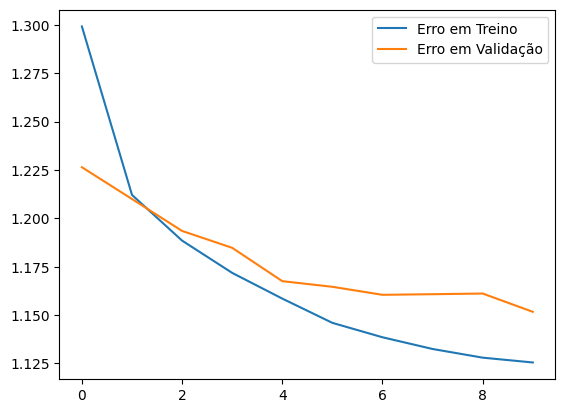

In [32]:
plt.plot(train_losses, label='Training Error')
plt.plot(val_losses, label='Validation Error')
plt.legend()
plt.show()

In [36]:
# Model evaluation
model.eval()

# Converting X_final_test to a PyTorch tensor
X_test_final_tensor = torch.tensor(X_final_test).to(device)

# Predictions
with torch.no_grad():
    predictions = model(X_test_final_tensor)

# Predicted labels (choosing the class index with highest probability)
predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()


In [37]:
print(classification_report(y_test_le, predicted_labels))

print(confusion_matrix(y_test_le, predicted_labels))

print(accuracy_score(y_test_le, predicted_labels))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       275
           1       0.87      0.92      0.89       224
           2       0.92      0.93      0.93       695
           3       0.83      0.69      0.75       159
           4       0.92      0.94      0.93       581
           5       0.81      0.64      0.71        66

    accuracy                           0.90      2000
   macro avg       0.87      0.84      0.85      2000
weighted avg       0.90      0.90      0.90      2000

[[249   3   5   0  18   0]
 [ 10 205   0   0   8   1]
 [  5   4 649  18  11   8]
 [  2   1  40 109   7   0]
 [ 13   5  11   4 547   1]
 [  1  18   3   0   2  42]]
0.9005


## Saving the model

### Saving only weights

In [38]:
##Saving
# Path where the model will be saved
PATH = "models/model_v3.pth"

# Saving only model weights
torch.save(model.state_dict(), PATH)


## Loading
# Initializing the model (architecture must be the same as the saved model)
model = Model(transformer_model)

# Loaded the saved weights 
model.load_state_dict(torch.load(PATH))

# Put the model in evaluation mode if it is for inference
model.eval()

Model(
  (transformer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

### Saving the complete model

In [39]:
torch.save(model, "models/model_v3_complete.pth")

# Loading the complete model
model = torch.load("models/model_v3_complete.pth")

# Putting the model in evaluation mode if it is for inference
model.eval()

Model(
  (transformer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

## Prediction for new data

In [40]:
# New sentence
sentence = "I'm happy today"

# Create a dataframe with the sentence
df_new = pd.DataFrame({'text': [sentence]})

# Applying the preprocessing function
df_new['transformed_text'] = df_new['text'].apply(data_preprocessing)

new_data = encode(df_new['transformed_text'], fast_tokenizer, max_len = max_length)

100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


In [43]:
# Converting new_data to a PyTorch tensor if it isn't already
new_data_tensor = torch.tensor(new_data).to(device)
model = model.to(device)

# Prediction
with torch.no_grad():
    prediction = model(new_data_tensor)

# Predicted labels (choosing the class index with highest probability)
predicted_label = torch.argmax(prediction, dim=1).cpu().numpy()

# Get the class name
class_name = le.inverse_transform(predicted_label)
print(class_name)

['joy']


In [44]:
torch.cuda.empty_cache()

### The end